# Uncertainty Evaluation (Resnet18 from scratch on SVHN)

In [41]:
# for Google Colab
%pip install torchinfo wandb

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import torch
import torchvision
import wandb
from tqdm.autonotebook import trange

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
!wandb login

wandb: Currently logged in as: wei2912. Use `wandb login --relogin` to force relogin


In [43]:
run = wandb.init(
    project="i2r-active-da-01_uncertainty",
    job_type="train",
    config={
        # parameters roughly similar to LIRR
        "optim": {
            "algorithm": "AdamW",
            "lr": 1e-3,
            "weight_decay": 5e-4,
        },
        "batch_size": 64,
        "num_epochs": 15,
        "cuda_device": 0,
        "architecture": "resnet34-cosc",
        "train_dataset": "svhn",
        "test_dataset": "mnist",
    },
)
config = run.config

run.tags += (config.architecture,)
if config.train_dataset == config.test_dataset:
    run.tags += (config.train_dataset,)
else:
    run.tags += (f"{config.train_dataset}-to-{config.test_dataset}",)

## SVHN Dataset

In [44]:
from torchvision.datasets import MNIST, SVHN
from torchvision.transforms import Compose, Grayscale, Resize, ToTensor

gs_to_tensor = Compose([Grayscale(3), Resize((32, 32)), ToTensor()])

match config.train_dataset:
    case "svhn":
        train_data = SVHN(
            "data/svhn", download=True, split="train", transform=ToTensor()
        )
    case "mnist":
        train_data = MNIST(
            "data/mnist", download=True, train=True, transform=gs_to_tensor
        )

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=config.batch_size,
    shuffle=True,
    pin_memory=True,
)

match config.test_dataset:
    case "svhn":
        test_data = SVHN("data/svhn", download=True, split="test", transform=ToTensor())
    case "mnist":
        test_data = MNIST(
            "data/mnist", download=True, train=False, transform=gs_to_tensor
        )

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=config.batch_size,
    pin_memory=True,
)

Using downloaded and verified file: data/svhn/train_32x32.mat


torch.Size([64, 3, 32, 32])
Label: 2


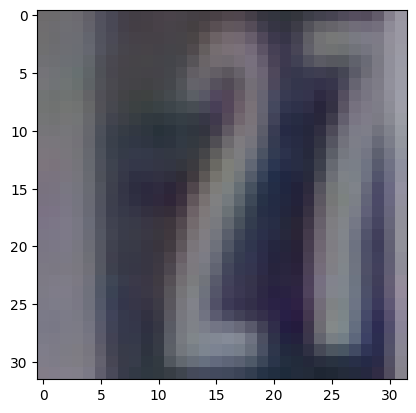

In [45]:
train_inputs, train_targets = next(iter(train_loader))
plt.imshow(torch.einsum("cwh->whc", train_inputs[0]))

print(train_inputs.size())
print(f"Label: {train_targets[0]}")

torch.Size([64, 3, 32, 32])
Label: 7


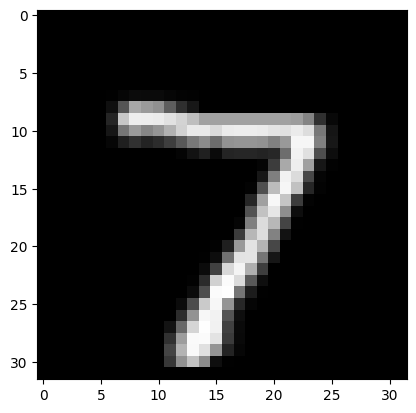

In [46]:
test_inputs, test_targets = next(iter(test_loader))
plt.imshow(torch.einsum("cwh->whc", test_inputs[0]))
assert train_inputs.size() == test_inputs.size()

print(test_inputs.size())
print(f"Label: {test_targets[0]}")

In [47]:
train_targets = []
for _, targets in list(train_loader):
    train_targets.extend([target for target in targets.tolist()])

test_targets = []
for _, targets in list(test_loader):
    test_targets.extend([target for target in targets.tolist()])

table = wandb.Table(columns=["train", "test"])
table.add_data(train_targets, test_targets)
run.log({"labels_figs": table})

## Training Setup

In [48]:
torch.cuda.set_device(config.cuda_device)
device = torch.device(
    f"cuda:{config.cuda_device}" if torch.cuda.is_available() else "cpu"
)

In [49]:
from torch.nn import CosineSimilarity, Linear, Module, Sequential
from torchinfo import summary
from torchvision.models import resnet18, resnet34


class CosC(Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.fc = Linear(**kwargs, bias=False)
        self.cos = CosineSimilarity(dim=1)

    def forward(self, x):
        x = x.reshape(x.size() + (1,))
        w_t = self.fc.weight.T.reshape((1,) + self.fc.weight.T.size())
        return self.cos(x, w_t)


match config.architecture:
    case "resnet18":
        model = resnet18(weights=None).to(device)
        model.fc = Linear(in_features=model.fc.in_features, out_features=10, bias=True)
    case "resnet18-cosc":
        model = resnet18(weights=None).to(device)
        model.fc = CosC(in_features=model.fc.in_features, out_features=10)
    case "resnet18-cosc-dim_32":
        model = resnet18(weights=None).to(device)
        model.fc = Sequential(
            Linear(in_features=model.fc.in_features, out_features=32, bias=True),
            CosC(in_features=32, out_features=10),
        )
    case "resnet18-cosc-dim_10":
        model = resnet18(weights=None).to(device)
        model.fc = Sequential(
            Linear(in_features=model.fc.in_features, out_features=10, bias=True),
            CosC(in_features=10, out_features=10),
        )
    case "resnet34-cosc":
        model = resnet34(weights=None).to(device)
        model.fc = CosC(in_features=model.fc.in_features, out_features=10)

summary(model, input_size=(config.batch_size, 3, 32, 32), depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 10]                  --
├─Conv2d: 1-1                            [64, 64, 16, 16]          9,408
├─BatchNorm2d: 1-2                       [64, 64, 16, 16]          128
├─ReLU: 1-3                              [64, 64, 16, 16]          --
├─MaxPool2d: 1-4                         [64, 64, 8, 8]            --
├─Sequential: 1-5                        [64, 64, 8, 8]            221,952
├─Sequential: 1-6                        [64, 128, 4, 4]           1,116,416
├─Sequential: 1-7                        [64, 256, 2, 2]           6,822,400
├─Sequential: 1-8                        [64, 512, 1, 1]           13,114,368
├─AdaptiveAvgPool2d: 1-9                 [64, 512, 1, 1]           --
├─CosC: 1-10                             [64, 10]                  5,120
Total params: 21,289,792
Trainable params: 21,289,792
Non-trainable params: 0
Total mult-adds (G): 4.79
Input size (MB): 

In [50]:
def save_model(epoch):
    if config.train_dataset == config.test_dataset:
        model_name = f"{config.architecture}-{config.train_dataset}"
    else:
        model_name = (
            f"{config.architecture}-{config.train_dataset}-to-{config.test_dataset}"
        )
    torch.save(model, f"{run.dir}/{model_name}-{epoch:03}.pt")
    wandb.save(f"{run.dir}/{model_name}-{epoch:03}.pt", base_path=run.dir)

In [51]:
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW

criterion = CrossEntropyLoss().to(device)
optimizer = AdamW(
    model.parameters(), lr=config.optim["lr"], weight_decay=config.optim["weight_decay"]
)

In [52]:
from sklearn.metrics import top_k_accuracy_score
import time


def train_epoch():
    model.train()

    start = time.monotonic()

    losses = []
    outputs = []
    targets = []
    for input, target in train_loader:
        if device is not None:
            input = input.to(device)
            target = target.to(device)

        output = model(input)
        loss = criterion(output, target)

        losses.append(loss.item())
        outputs.extend(output.squeeze().tolist())
        targets.extend(target.tolist())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    end = time.monotonic()

    return {
        "time": end - start,
        "loss": sum(losses) / len(losses),
        "top1": top_k_accuracy_score(targets, outputs, k=1, labels=range(10)),
    }

In [53]:
def test_epoch():
    model.eval()

    start = time.monotonic()

    losses = []
    outputs = []
    targets = []
    for input, target in test_loader:
        if device is not None:
            input = input.to(device)
            target = target.to(device)

        output = model(input)
        loss = criterion(output, target)

        losses.append(loss.item())
        outputs.extend(output.squeeze().tolist())
        targets.extend(target.tolist())

    end = time.monotonic()

    return (
        outputs,
        targets,
        {
            "time": end - start,
            "loss": sum(losses) / len(losses),
            "top1": top_k_accuracy_score(targets, outputs, k=1, labels=range(10)),
        },
    )

### Uncertainty Metrics

In [54]:
def softmax(outputs):
    return np.exp(outputs) / np.sum(np.exp(outputs), axis=1).reshape(
        (outputs.shape[0], 1)
    )


def predictive_entropy(pss):
    return (-pss * np.log(pss)).sum(axis=1)


def margin(pss):
    inds = np.argsort(pss, axis=1)
    max2s = np.take_along_axis(pss, inds[:, -2:], axis=1)
    return max2s[:, 1] - max2s[:, 0]

In [55]:
pss = softmax(np.array([[1, 2, 3, 4], [2, 4, 3, 6]]))
print(pss)
print(predictive_entropy(pss))
print(margin(pss))

[[0.0320586  0.08714432 0.23688282 0.64391426]
 [0.01521943 0.11245721 0.0413707  0.83095266]]
[0.94753696 0.59508669]
[0.40703144 0.71849545]


In [56]:
save_model(0)

df_epochs = []
for epoch in trange(1, config.num_epochs + 1):
    train_metrics = train_epoch()
    save_model(epoch)
    outputs, targets, test_metrics = test_epoch()

    targets, outputs = np.array(targets), np.array(outputs)
    pss = softmax(outputs)
    cs = np.argmax(pss, axis=1) == targets
    pes = predictive_entropy(pss)
    ms = margin(pss)

    df_epoch = pd.DataFrame(
        data=zip([epoch] * len(targets), targets, outputs, pss, cs, pes, ms),
        columns=[
            "epoch",
            "target",
            "output",
            "probs",
            "is_correct",
            "predictive_entropy",
            "margin",
        ],
    )
    df_epochs.append(df_epoch)

    run.log(
        {
            "epoch": epoch,
            "train": train_metrics,
            "test": test_metrics,
            "uncertainty_metrics": wandb.Table(data=df_epoch),
        }
    )

  0%|          | 0/15 [00:00<?, ?it/s]

In [57]:
df = pd.concat(df_epochs)
df.to_pickle(f"{run.dir}/df_uncertainty_metrics.pickle")
wandb.save(f"{run.dir}/df_uncertainty_metrics.pickle", base_path=run.dir)
df

epoch  target                                             output  \
0         1       7  [-0.37217292189598083, -0.0694132074713707, 0....   
1         1       2  [-0.3722030520439148, -0.06942062824964523, 0....   
2         1       1  [-0.37324294447898865, -0.06582169979810715, 0...   
3         1       0  [0.35472339391708374, -0.07055463641881943, -0...   
4         1       4  [-0.20022451877593994, -0.02035610005259514, -...   
...     ...     ...                                                ...   
9995     15       2  [-0.26199182868003845, -0.10265100002288818, 0...   
9996     15       3  [-0.25526994466781616, -0.0929105281829834, -0...   
9997     15       4  [-0.24737003445625305, -0.09002421051263809, -...   
9998     15       5  [-0.2747758626937866, -0.10013245046138763, -0...   
9999     15       6  [-0.18716202676296234, -0.057107701897621155, ...   

                                                  probs  is_correct  \
0     [0.06415879560037432, 0.08684465136023894, 0.2...       False   
1     [0.06415268438820987, 0.08683835131142106, 0.2...        True   
2     [0.06412295133463305, 0.08720168025106673, 0.2...       False   
3     [0.13576705453627866, 0.0887357234189143, 0.08...       False   
4     [0.08004618909234638, 0.09582007847530058, 0.0...        True   
...                                                 ...         ...   
9995  [0.07735568324385803, 0.09071791685548249, 0.2...        True   
9996  [0.06794384498354662, 0.07992118578879023, 0.0...        True   
9997  [0.06904845051015857, 0.08081432694087773, 0.0...       False   
9998  [0.06684851587685776, 0.07960465051817928, 0.0...       False   
9999  [0.08041400643649604, 0.09158272803096176, 0.0...       False   

      predictive_entropy    margin  
0               2.151328  0.046039  
1               2.151256  0.046020  
2               2.151302  0.045996  
3               2.242338  0.025790  
4               2.216621  0.146377  
...                  ...       ...  
9995            2.191231  0.174866  
9996            2.182301  0.028424  
9997            2.190811  0.026967  
9998            2.189416  0.029414  
9999            2.211980  0.155793  

[150000 rows x 7 columns]

## Analysis

In [58]:
fig = px.histogram(
    df,
    x="predictive_entropy",
    color="is_correct",
    animation_frame="epoch",
    barmode="overlay",
    histnorm="probability",
    # range_x=(2.15, 2.3),
    range_y=(0, 1),
)
fig.update_traces(xbins_size=0.005)
fig.update_layout(width=600, height=600)
fig.write_html(f"{run.dir}/hist_predictive_entropy.html", auto_play=False)
fig.show()

In [59]:
fig = px.histogram(
    df,
    x="margin",
    color="is_correct",
    barmode="overlay",
    animation_frame="epoch",
    histnorm="probability",
    # range_x=(0, 0.2),
    range_y=(0, 1),
)
fig.update_traces(xbins_size=0.01)
fig.update_layout(width=600, height=600)
fig.write_html(f"{run.dir}/hist_margin.html", auto_play=False)
fig.show()

In [60]:
table = wandb.Table(columns=["predictive_entropy", "margin"])
table.add_data(
    wandb.Html(f"{run.dir}/hist_predictive_entropy.html"),
    wandb.Html(f"{run.dir}/hist_margin.html"),
)
run.log({"uncertainty_figs": table})

if input("Finish the WandB run? [Y/n] ").strip().lower() == "y":
    run.finish()

Finish the WandB run? [Y/n] y
